In [3]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

print(f"Using {device} device")#cuda uses gpu

Using cpu device


In [10]:
epochs = 10#no of cl\ycles
loss_steps = 20
batch_size = 6# no of images seen per iteration
train_folder = "./dataset/Training"
test_folder = "./dataset/Testing"
transformation = transforms.Compose(
    [
        transforms.Resize(256),#make it all one size
        transforms.RandomCrop(224),#resnet uses 224 p
        transforms.RandomHorizontalFlip(p=0.25),# probability
        transforms.RandomVerticalFlip(p=0.25),
        transforms.RandomApply((transforms.RandomRotation((-20, 20),center=(112,112)),), p=0.5),# keep the centre as 112,112 and randomly rotate 20 deg
        transforms.ToTensor(),
    ]
)

classes_interest = os.listdir(train_folder)#gets the names of the folders in classesintreser 
train_dataset = torchvision.datasets.ImageFolder(
    root=train_folder, transform=transformation#root and transform are the parameters in the orchvision.datasetimage folder class
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_folder, transform= transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),#same for testing
        transforms.ToTensor(),
    ]
))

classes = train_dataset.classes#you ge the names of the folders
classes_dict = train_dataset.class_to_idx
class_dict_inverted = {v: k for k, v in classes_dict.items()}
print(f"Classes             = {classes}")
print(f"Classes Dict (k: v) = {classes_dict}")
print(f"Classes Dict (v: k) = {class_dict_inverted}")# a dictionary where you invert the variable and the key

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,# load the data
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

Classes             = ['glioma', 'meningioma', 'notumor', 'pituitary']
Classes Dict (k: v) = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Classes Dict (v: k) = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


tensor([3, 2, 1, 0, 3, 3])
torch.Size([6, 3, 224, 224]) torch.float32 torch.Size([6]) torch.int64


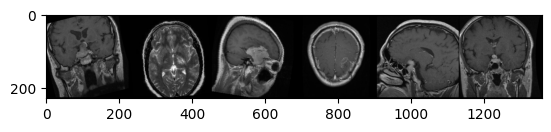

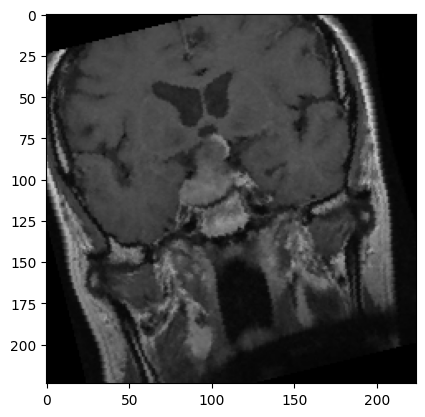

Label: pituitary


In [11]:
def imshow(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = enumerate(train_dataloader)#it gives you a list of ordered tuples 

_, data = next(dataiter)# use _ for waste variables and next for the first time starts form (a,1) 
images, labels = data
print(labels)
print(images.shape, images.dtype, labels.shape, labels.dtype)#shape determines the size and ype of the array

imshow(torchvision.utils.make_grid(images))

image_ = images[0]
label_ = classes[labels[0]]
imshow(image_)
print(f"Label: {label_}")# show the images 

In [16]:
net = torchvision.models.resnet50(pretrained=True)# resnet model is stored in net variable the weights and all


n_inputs = net.fc.in_features#input 

net.fc = nn.Sequential(
    nn.Linear(n_inputs, 2048),#nn contains the layers we will use # fully connected network
    nn.SELU(), # introduces the step function more complexity after a fully connected layer you have a step function else u can make allthe layers into one 
    nn.Dropout(p=0.4),# each neuron might hae a 40 % chance of getting deactivated # increases the generalness
    nn.Linear(2048, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4),# because we have 4 labels
    nn.Softmax(dim=1),# sum of all things is 1 softax is e^x / e^x+e^y so essentially higher ones goes higher and the lower ones go lower 
)
    
for name, child in net.named_children():
    for name2, params in child.named_parameters():# calculate the gradient of the of the layer
        params.requires_grad = True# setting up a flag that when it comes to this you have to set up a gradient

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
if cuda:
    net = net.cuda()

criterion = nn.CrossEntropyLoss()# loss essentially figures out how differnet the output is from the expected output
optimizer = optim.SGD(net.parameters(), lr=0.0003, momentum=0.9, weight_decay=0.001)#hyperparameters # change the hyperparameters 
# lr - learning rate how much you change weight values
# weight decay - higher weight is higher loss and higher weight essentially 
# momentum - reduce the amt of change you make if less 1 

    

In [21]:
best_acc = 0.0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
for epoch in range(epochs):  
    start_time = time.time()# gives you the utc timestamp
    epoch_loss = 0.0
    iter_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    for i, data in enumerate(train_dataloader, 0): #every enumerate augmentes the dataset differently# 0 is the start index
        inputs, labels = data#inputs - images the batch size # labels - corresponding labels 
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()# class that does the backward propagation to reduce loss # it sets up a zero gradient

        outputs = net(inputs)# run the input through all the layers and give you the output
        loss = criterion(outputs, labels)#cross entropy loss function
        loss.backward()# internally computes how much weights change
        optimizer.step()# changes the weights based on the previous step

        with torch.no_grad():# with is a context manager and it does everything using torch.nograd() so while testing we dont really want the gradient we need it only during training
            iter_loss += loss.item()#loss.item gives me the loss of 1st 8 images iterloss it gives me all of them 
            epoch_loss += loss.item()
            if i % loss_steps == (loss_steps - 1):# while training the model it gives me the loss every 20 iterations 
                acc = 0.0
                _, predicted = torch.max(outputs.data, 1)# list of predicted outputs in the 1st dimension # htese are tensors so it is easier for us to claculate the max using torch
                total = labels.size(0)# size of the column in the 2d aray here 8 
                correct = (predicted == labels).sum().item()# it tells you how many of the elemnets are predicted correctly 
                epoch_correct += correct# total number of corrects 
                epoch_total += total# total number of iterations 
                acc = correct / total# accuracy
                print(
                    f"[Epoch {epoch + 1} - Iter {i + 1}] loss: {iter_loss / loss_steps} acc: {acc}"
                )
                iter_loss = 0.0


    history["train_loss"].append(epoch_loss / len(train_dataloader))# a dictionary already defined to store 
    history["train_acc"].append(epoch_correct / epoch_total)

    print(
        f"[Epoch {time.time() - start_time}]\ntrain_loss: {history['train_loss'][-1]}\ttrain_acc: {history['train_acc'][-1]}")

[Epoch 1 - Iter 20] loss: 1.3854453444480896 acc: 0.3333333333333333
[Epoch 1 - Iter 40] loss: 1.3866674065589906 acc: 0.3333333333333333
[Epoch 1 - Iter 60] loss: 1.3650395333766938 acc: 0.5
[Epoch 1 - Iter 80] loss: 1.3330511927604676 acc: 0.3333333333333333
[Epoch 1 - Iter 100] loss: 1.3295682072639465 acc: 0.3333333333333333
[Epoch 1 - Iter 120] loss: 1.3282843589782716 acc: 0.16666666666666666
[Epoch 1 - Iter 140] loss: 1.317754679918289 acc: 0.8333333333333334
[Epoch 1 - Iter 160] loss: 1.2949941515922547 acc: 0.5
[Epoch 1 - Iter 180] loss: 1.2784226536750793 acc: 0.3333333333333333
[Epoch 1 - Iter 200] loss: 1.2777044117450713 acc: 0.3333333333333333
[Epoch 1 - Iter 220] loss: 1.2883939445018768 acc: 0.16666666666666666
[Epoch 1 - Iter 240] loss: 1.2365756034851074 acc: 0.6666666666666666
[Epoch 1 - Iter 260] loss: 1.1931037306785583 acc: 0.6666666666666666
[Epoch 1 - Iter 280] loss: 1.1793368458747864 acc: 0.8333333333333334
[Epoch 1 - Iter 300] loss: 1.207722580432892 acc: 0.8

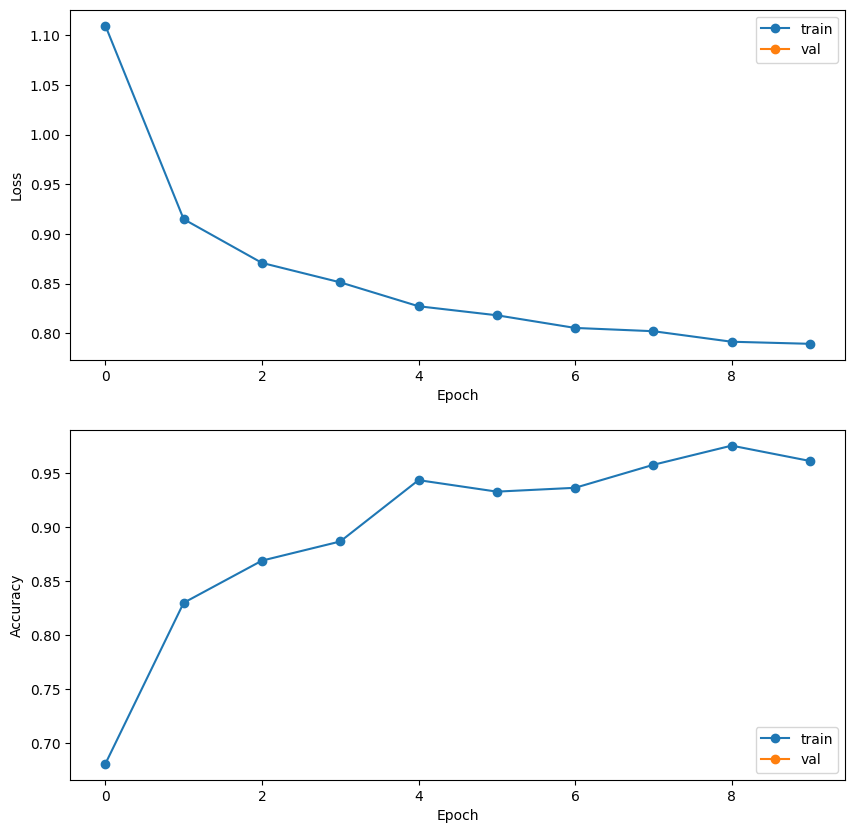

In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)# you have 2 plots
plt.plot(history["train_loss"], "-o")#-o is for the way you are plotting the graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train"], loc="upper right")
plt.subplot(2, 1, 2)
plt.plot(history["train_acc"], "-o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train"], loc="lower right")
plt.show()

In [23]:
net.eval()# test 
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        test_acc += correct / total

print(
    f"[Test]\nloss: {test_loss / len(test_dataloader)}\tacc: {test_acc / len(test_dataloader)}"
)

[Test]
loss: 0.7672835917777667	acc: 0.9771689497716899


In [24]:
torch.save(net.state_dict(), "./model.pth")# saving the model